In [32]:
import numpy as np 
import pandas as pd 
import operator
from matplotlib.pyplot import figure

In [2]:
n = 200000
n1 = 4
hour_total = 8
marks = [0,1,2,3,4,5]
in_time = [0,1]
employees = [0,1,2,3,4,5,6,7,8,9,10,11,12]
hour = range(hour_end)
type_task = [0,1,2,3,4,5]
start_hour = np.random.choice(hour, n)
load_percent = np.ravel(np.random.rand(n,1))
marks_l = np.random.choice(marks, n)
in_time_l = np.random.choice(in_time, n)
employees_l = np.random.choice(employees, n)
type_task_l = np.random.choice(type_task, n)
metric = np.log2(marks_l + 2) * np.log2(in_time_l + 2)

In [3]:
df = pd.DataFrame({'loading_percent': load_percent, 'employees': employees_l, 'task_type': type_task_l, 'start_hour': start_hour,
                  'metric': metric})

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 2)]
# Minimum number of samples required to split a node
min_samples_split = [4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 600, 1000], 'max_features': ['sqrt'], 'max_depth': [10, 40], 'min_samples_split': [4], 'min_samples_leaf': [1, 2], 'bootstrap': [True]}


In [8]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(df.loc[:, df.columns != 'metric'], df['metric'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, total= 3.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, total= 3.3min
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, total= 2.8min
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, total=  53.5s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, total=  53.7s
[CV] n_estimators=200, min_samples_s

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 13.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [13]:
best_params = rf_random.best_params_

In [14]:
base_model = RandomForestRegressor(random_state = 42).set_params(**best_params)
base_model.fit(df.loc[:, df.columns != 'metric'], df['metric'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [36]:
def predict(model,hour,type_task,employees,loading_percent):
    list_pred = {}
    for i in employees:
        pred_arr = np.array(list([loading_percent,i,type_task,hour])).reshape(1,-1)
        list_pred[i] = model.predict(pred_arr)
    return max(list_pred.items(), key=operator.itemgetter(1))[0]


In [37]:
predict(base_model,6,2,employees,0.5)

0

In [38]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

C:\Users\genri\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\genri\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[100.75332119]


In [40]:
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

In [41]:
date = np.array('2020-03-01', dtype=np.datetime64)

In [52]:
total_dates = 120
mean_tasks = 10000
date_arr = date + np.arange(total_dates)
total_tasks = np.ravel( (mean_tasks * np.random.rand(total_dates,1) )).astype(int)

In [54]:
df_dates = pd.DataFrame({'total_tasks': total_tasks, 'date': date_arr})
df_dates = df_dates.set_index('date')

In [72]:
from pylab import rcParams
rcParams['figure.figsize'] = 17, 8

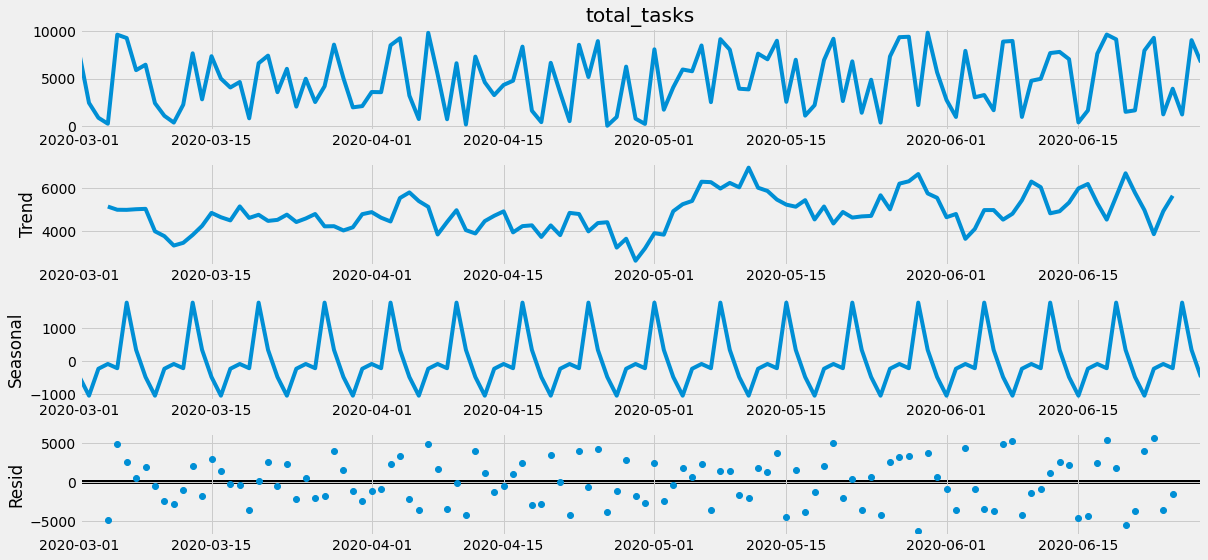

In [73]:
decomposition = sm.tsa.seasonal_decompose(df_dates['total_tasks'], model='additive')
fig = decomposition.plot()
plt.show()

In [74]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [79]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_dates['total_tasks'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:94560.77864355077
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2131.038132606254
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:54865.03705838543
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1832.5896252202497
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2114.037072901783
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2068.2135774110575
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1870.0630322577645
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1833.843204088944
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2335.9089015992176
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2099.0452305913113
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2091.286397822342
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1815.9044975596682
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2129.268664256192
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2051.035561340634
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1871.5261620646447
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1824.7609123984278
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:55674.2063615155
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2081.285175188997
ARI

In [82]:
mod = sm.tsa.statespace.SARIMAX(df_dates['total_tasks'],
                                            order=(0,1,1),
                                            seasonal_order=(1,1,1,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()

In [83]:
pred = results.get_prediction(start=pd.to_datetime('2020-06-29'), dynamic=False)
pred_ci = pred.conf_int()

In [86]:
pred.predicted_mean

2020-06-29    5280.529938
Freq: D, dtype: float64